In [13]:
import pandas as pd
import glob
import os
import json

# Define the folder path
folder_path = "raw_data"  # Change this to your actual folder path

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read each CSV file and store them in a list
df_list = [pd.read_csv(file) for file in csv_files]

# Concatenate all DataFrames into one
df_combined = pd.concat(df_list, ignore_index=True)

# cleaning
df_combined = df_combined.assign(snp = df_combined.snp.str.replace('`', ''))

# extract the SNP data
df_combined[['chrom', 'pos', 'default_alternate']] = df_combined.snp.str.extract(r'(\d+):(\d+)_([A-Za-z])')

# add reference alleles
reference = pd.read_csv('reference_genome_hg19.csv').astype(str)

# add onto main df
df_combined = df_combined.merge(reference, how = 'left')

# add custom risk alleles (what we want the alleles to be)
custom_risk_alleles = pd.read_csv('custom_risk_alleles.csv').astype(str)
df_combined = df_combined.merge(custom_risk_alleles, how = 'left')

In [14]:
# drop the n = 0 rows
df_combined = df_combined[df_combined.n_total > 0]

In [15]:
# rename necessary cols
df_combined = df_combined.assign(

    # clean
    phenocode = df_combined.phenotype,
    phenostring = df_combined.description,
    clean_phenotype = df_combined.description.str.lower().str.replace('[ -]', '_', regex = True).str.replace("[',\\]\\[\\(\\)/;&\\.]", "", regex = True),

    # rename
    reference = df_combined.reference_hg19,
    num_samples = df_combined.n_total,
    num_controls = df_combined.n_controls,
    num_cases = df_combined.n_cases,
    se = df_combined.SE,

    maf = round(df_combined.assign(allele_freq2 = 1 - df_combined.allele_freq)[['allele_freq', 'allele_freq2']].min(axis = 1), 2),

    # capitalize the first letter
    category = df_combined.group.str.slice(0,1).str.upper() + df_combined.group.str.slice(1),

    # retype
    chrom = df_combined.chrom.astype(int),
    pos = df_combined.pos.astype(int)
)

df_combined['or'] = df_combined.OR
df_combined['af'] = 1 - df_combined.maf

In [16]:
# filter out 8:143778381_A because we don't have the right alternate allele
df_combined = df_combined[df_combined.snp != '8:143778381_A']

In [17]:
def create_alternate_allele(row):
    if row['reference'] != row['default_alternate']:
        return row['default_alternate']
    elif row['reference'] == row['custom_reference_allele']:
        return row['custom_risk_allele']
    else:
        return row['custom_reference_allele']

df_combined['alternate'] = df_combined.apply(create_alternate_allele, axis=1)

In [33]:
# if there are no custom alleles, use the ones we have
df_combined.loc[df_combined.custom_reference_allele.isna(), 'custom_reference_allele'] = df_combined.loc[df_combined.custom_reference_allele.isna(), 'reference']
df_combined.loc[df_combined.custom_risk_allele.isna(), 'custom_risk_allele'] = df_combined.loc[df_combined.custom_risk_allele.isna(), 'alternate']

In [34]:

df_combined[['chrom', 'pos','reference', 'default_alternate', 'custom_reference_allele',  'custom_risk_allele', 'alternate']].drop_duplicates().sort_values(by=['chrom', 'pos'])

,chrom,pos,reference,default_alternate,custom_reference_allele,custom_risk_allele,alternate
4041,1,198394253,T,T,T,G,G
10099,2,43078360,G,T,T,G,T
28092,2,144248905,T,T,T,C,C
54357,3,15557682,T,A,A,T,A
18186,5,1322468,G,A,A,G,A
26073,6,26843517,A,A,C,A,C
32134,7,27303632,G,A,G,A,A
58395,7,27560733,T,T,C,T,C
60414,7,41266132,G,A,G,A,A
8079,7,81431397,C,T,T,C,T


In [35]:
# check that there are no SNPs with the same reference and alternate allele
if df_combined[df_combined.reference_hg19 == df_combined.alternate][['chrom', 'pos','reference', 'default_alternate', 'custom_reference_allele',  'custom_risk_allele', 'alternate']].shape[0] > 0:
    raise ValueError("There are SNPs with the same reference and alternate allele.")

In [36]:
final_cols = [
    'chrom', 'pos', 'reference', 'alternate', 'p',
    'num_cases', 'num_controls', 'maf', 'af', 'beta', 'se', 'or', 
    'custom_reference_allele', 'custom_risk_allele'
]

In [37]:
# since we're using risk allele, all betas will be positive, and all ORs are > 1
df_combined['beta'] = df_combined['beta'].abs()
df_combined['or'] = df_combined['or'].apply(lambda x: x if x >= 1 else 1/x)

In [38]:
# sort very important for Pheweb
df_combined = df_combined.sort_values(['phenocode', 'chrom', 'pos'])

In [39]:
# final file
df_combined[['phenocode', 'phenostring', 'clean_phenotype', 'category'] + final_cols].to_csv('all_data.csv', index = False)

<Axes: >

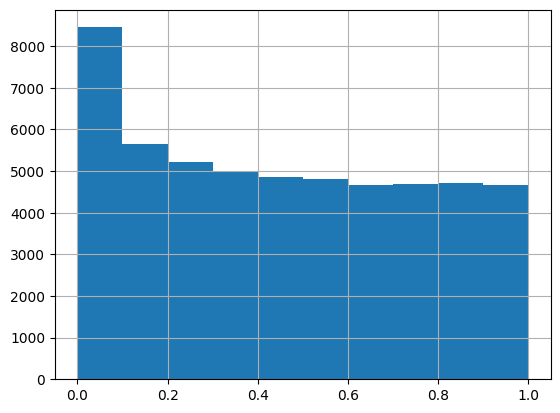

In [40]:
# note that the p-value is raw
df_combined.p.hist()

## Formatting 

I need to format the files a la Github specifications. One file per phenotype

In [41]:
# do any phenocodes have zero samples? 
n_totals = df_combined.groupby('phenocode').n_total.sum()
pd.Series(n_totals[n_totals == 0].index)

Series([], Name: phenocode, dtype: float64)

In [42]:
unique_phenotypes = df_combined[['phenocode', 'phenostring', 'category', 'clean_phenotype']].drop_duplicates()

# check for consistent phenotype categories
if unique_phenotypes.shape[0] != df_combined.phenocode.nunique():
    raise ValueError("Non-unique phenotype categories. One or more phenotypes have multiple categories")

In [43]:
df_combined.columns

Index(['phenotype', 'snp', 'adjustment', 'beta', 'OR', 'SE', 'p', 'type',
       'n_total', 'n_cases', 'n_controls', 'HWE_p.min', 'allele_freq',
       'n_no_snp', 'k_studies', 'tau2', 'I2.percent', 'Q', 'Q.df', 'Q.p',
       'beta.fixed', 'OR.fixed', 'SE.fixed', 'p.fixed', 'beta.random',
       'OR.random', 'SE.random', 'p.random', 'description', 'group', 'chrom',
       'pos', 'default_alternate', 'reference_hg19', 'custom_risk_allele',
       'custom_reference_allele', 'phenocode', 'phenostring',
       'clean_phenotype', 'reference', 'num_samples', 'num_controls',
       'num_cases', 'se', 'maf', 'category', 'or', 'af', 'alternate'],
      dtype='object')

In [44]:
# remove all files in folder
import os
import glob

files = glob.glob('clean_data/*.csv')
for f in files:
    os.remove(f)

# make a file for each phenotype
for pheno in unique_phenotypes.clean_phenotype:
    df_combined[df_combined.clean_phenotype == pheno][final_cols].to_csv('clean_data/' + str(pheno) + '.csv', index = False)

In [45]:
pheno_df = unique_phenotypes.assign(
    assoc_files = 'clean_data/' + unique_phenotypes.clean_phenotype + '.csv'
    )[['assoc_files',  'category', 'phenocode', 'phenostring']]

pheno_df.to_csv('pheno-list.csv', index = False)

In [46]:
pheno_df

,assoc_files,category,phenocode,phenostring
4041,clean_data/dermatophytosis__dermatomycosis.csv,Infectious diseases,110.00,Dermatophytosis / Dermatomycosis
4042,clean_data/dermatophytosis.csv,Infectious diseases,110.10,Dermatophytosis
4043,clean_data/dermatophytosis_of_nail.csv,Infectious diseases,110.11,Dermatophytosis of nail
4044,clean_data/althetes_foot.csv,Infectious diseases,110.12,Althete's foot
4045,clean_data/dermatophytosis_of_the_body.csv,Infectious diseases,110.13,Dermatophytosis of the body
...,...,...,...,...
6054,clean_data/effects_radiation_nos.csv,Injuries & poisonings,990.00,Effects radiation NOS
6055,clean_data/sepsis_and_sirs.csv,Injuries & poisonings,994.00,Sepsis and SIRS
6056,clean_data/systemic_inflammatory_response_synd...,Injuries & poisonings,994.10,Systemic inflammatory response syndrome (SIRS)
6057,clean_data/sepsis.csv,Injuries & poisonings,994.20,Sepsis


In [47]:

json_df = pheno_df.assign(phenocode = pheno_df.phenocode.astype(str))

# Ensure 'assoc_files' becomes a list of one file per row
json_df["assoc_files"] = json_df["assoc_files"].apply(lambda x: [x])

# Convert to list of dicts
pheno_json = json_df.to_dict(orient="records")

# Write to JSON file
with open("pheno-list.json", "w") as f:
    json.dump(pheno_json, f, indent=2)